In [399]:
import os
import sys
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.utils.tensorboard import SummaryWriter

In [412]:
def load_data(ticker):
    ticker = yf.Ticker(ticker)
    historical_data = ticker.history(period="10y")
    close = np.array(historical_data.Close)
    open = np.array(historical_data.Open)

    next_open = open[2:]
    next_close = close[2:]
    last_open = open[:-2]
    last_close = close[:-2]
    open = open[1:-1]
    close = close[1:-1]

    vol = np.array(historical_data.Volume)[1:-1]
    vol = vol / np.mean(vol)

    #return np.concatenate([[(close - open) / open], [(last_close - open) / last_close], [vol]]), (next_open - close) / next_open, open

    obj = (next_close - next_open) / next_open
    data = np.concatenate([[(close - open) / open],
                           [(next_open - close) / close],
                           [vol]])
    return data, obj


data, obj = load_data("TSLA")
data = data[:, -50:].astype(np.float32)
obj = obj[-50:].astype(np.float32)

data = data[:, -500:-50].astype(np.float32)
obj = obj[-500:-50].astype(np.float32)

In [413]:
# Define the dataset
window_size = 30
n_samples = obj.shape[0]

# Generate some synthetic stock returns as an example
targets = obj[window_size:]  # The target is to predict the next return after the window

# Prepare the rolling window inputs and corresponding targets
inputs = []
for i in range(n_samples - window_size):
    inputs.append(data[:, i:i + window_size])

inputs = np.array(inputs)

# Convert to PyTorch tensors
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets).unsqueeze(1)

In [406]:
# Define the 1D convolutional model
class StockReturnPredictor(nn.Module):
    def __init__(self):
        super(StockReturnPredictor, self).__init__()
        ks = 10
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=6, kernel_size=ks)
        self.conv2 = nn.Conv1d(in_channels=6, out_channels=3, kernel_size=ks)
        self.fc1 = nn.Linear(3 * (window_size - ks - ks + 2), 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.tanh(x)
        x = self.conv2(x)
        x = torch.tanh(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.fc1(x)
        return x

# Instantiate the model, define loss and optimizer
model = StockReturnPredictor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 4000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Add batch dimension and channel dimension (batch_size, channels, sequence_length)
    inputs_batch = inputs
    
    outputs = model(inputs_batch)
    
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

print("Training finished.")

Epoch [100/4000], Loss: 0.0000
Epoch [200/4000], Loss: 0.0000
Epoch [300/4000], Loss: 0.0000
Epoch [400/4000], Loss: 0.0000
Epoch [500/4000], Loss: 0.0000
Epoch [600/4000], Loss: 0.0000
Epoch [700/4000], Loss: 0.0000
Epoch [800/4000], Loss: 0.0000
Epoch [900/4000], Loss: 0.0000
Epoch [1000/4000], Loss: 0.0000
Epoch [1100/4000], Loss: 0.0000
Epoch [1200/4000], Loss: 0.0000
Epoch [1300/4000], Loss: 0.0000
Epoch [1400/4000], Loss: 0.0000
Epoch [1500/4000], Loss: 0.0000
Epoch [1600/4000], Loss: 0.0000
Epoch [1700/4000], Loss: 0.0000
Epoch [1800/4000], Loss: 0.0000
Epoch [1900/4000], Loss: 0.0000
Epoch [2000/4000], Loss: 0.0000
Epoch [2100/4000], Loss: 0.0000
Epoch [2200/4000], Loss: 0.0000
Epoch [2300/4000], Loss: 0.0000
Epoch [2400/4000], Loss: 0.0000
Epoch [2500/4000], Loss: 0.0000
Epoch [2600/4000], Loss: 0.0000
Epoch [2700/4000], Loss: 0.0000
Epoch [2800/4000], Loss: 0.0000
Epoch [2900/4000], Loss: 0.0000
Epoch [3000/4000], Loss: 0.0000
Epoch [3100/4000], Loss: 0.0000
Epoch [3200/4000]

In [414]:
model.eval()
from sklearn.metrics import mean_squared_error
with torch.no_grad():
    test_outputs = model(inputs).squeeze()
    test_loss = mean_squared_error(targets.numpy(), test_outputs.numpy())
    print(f'Test Loss (MSE): {test_loss:.4f}')

RuntimeError: Input type (double) and bias type (float) should be the same

In [415]:

pred = outputs.detach().cpu().numpy().T[0]
pred = test_outputs
obj = targets.detach().cpu().numpy().T[0]



exp = np.sqrt(np.dot(pred, pred) / len(pred))
real = (np.dot(pred, obj) / len(pred)) / exp

print(exp, real)

obj_sort = np.argsort(obj)
plt.plot(np.cumsum(pred[obj_sort]), label="pred")
plt.plot(np.cumsum(obj[obj_sort]), label="obj")

plt.legend()

ValueError: shapes (20,) and (0,) not aligned: 20 (dim 0) != 0 (dim 0)

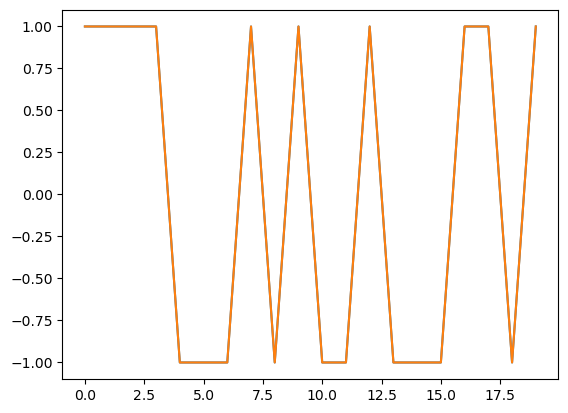

In [405]:
plt.plot((np.sign(pred)), label="pred")
plt.plot((np.sign(obj)), label="obj")